In [27]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pyemma
import seaborn as sns
plt.rcParams['axes.linewidth'] = 1

In [2]:
sys.path.append("/home/t/writhe/")
import package
from package.visualize import visualize
from package.utils import utils
from package.msmtool import msmtool

In [3]:
#tic = np.load("/home/t/msm/ntxd/data/trunc/dict.data/tica.dic.data/p.npy")[...,:2]
data = np.load("data.npy") #padded data matrix containing dists, Salpha, dssp

In [4]:
dist_tic = pyemma.coordinates.tica(data=data[:,:,:-2,:].reshape(-1,49*21),
                                   dim=2,
                                  lag=30).fit_transform(
                                          data[:,:,:-2,:].reshape(-1,49*21))

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

In [5]:
sa_tic = pyemma.coordinates.tica(data=data[:,:,:-1,:].reshape(-1,50*21)[:,:-15],
                                   dim=2,
                                   lag=30).fit_transform(
                                          data[:,:,:-1,:].reshape(-1,50*21)[:,:-15])

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

In [6]:
dssp_tic = pyemma.coordinates.tica(
    data=np.delete(data,-2,axis=-2).reshape(-1,50*21),
    dim=2,lag=30).fit_transform(np.delete(data,-2,axis=-2).reshape(-1,50*21))

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

In [7]:
#all features 
tic = pyemma.coordinates.tica(data=data.reshape(-1,51*21),
                              dim=2,
                              lag=30).fit_transform(data.reshape(-1,51*21))

calculate covariances:   0%|                                                                                  …

calculate covariances:   0%|                                                                                  …

Text(0.5, 1.0, 'TICA Projections')

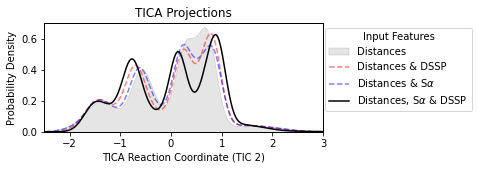

In [36]:
plt.figure(figsize=(5,2))

sns.kdeplot(-1*dist_tic[:,1],bw_adjust=2.5,
            color="gray",
            alpha=.2, fill=True, lw=.2, label="Distances")

sns.kdeplot(-1*dssp_tic[:,1],bw_adjust=2.5, 
            color="red",ls="--", 
            label=r"Distances & DSSP",
            alpha=.5)

sns.kdeplot(-1*sa_tic[:,1],bw_adjust=2.5, 
            color="blue",ls="--", 
            label=r"Distances & S$\alpha$",
            alpha=.5)

sns.kdeplot(-1*tic[:,1], bw_adjust=2.5,
            color="black", 
            label=r"Distances, S$\alpha$ & DSSP")

plt.ylabel("Probability Density")
plt.xlabel("TICA Reaction Coordinate (TIC 2)")
plt.legend(title = "Input Features",bbox_to_anchor=[1.55,1])
plt.xlim(-2.5,3)
plt.ylim(0,.7)
plt.title("TICA Projections")

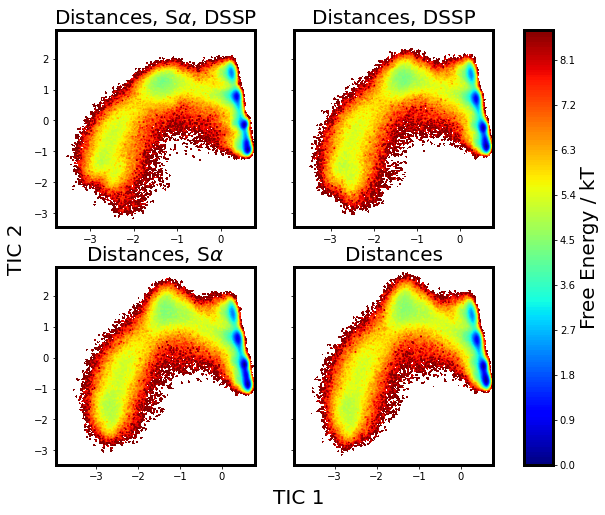

<Figure size 432x288 with 0 Axes>

In [26]:
fig, axes = plt.subplots(2,2,
                         figsize=(9,8),
                         sharey=True,
                        )
ax=axes.flat

visualize.fes2d(tic, title=r"Distances, S$\alpha$, DSSP",
                x_label="", y_label="", ax = ax[0],cbar_=False)

visualize.fes2d(dssp_tic, title="Distances, DSSP",
                x_label="", y_label="", ax=ax[1],cbar_=False)

visualize.fes2d(sa_tic, title=r"Distances, S$\alpha$",
                x_label="", y_label="", ax=ax[2],cbar_=False)

im=visualize.fes2d(dist_tic, title="Distances",
                x_label="", y_label="", ax=ax[3],cbar_=False)



fig.supxlabel("TIC 1", size=20,y=.05)
fig.supylabel("TIC 2",size=20,x=.05)
cbar = fig.colorbar(im,ax=[axes[i,-1] for i in range(2)],
                    cmap="jet",
                    orientation = "vertical",
                    aspect=15)
cbar.set_label("Free Energy / kT", size = 20) 
plt.subplots_adjust(right=.8)
plt.show()
plt.tight_layout()

In [ ]:
### ends ####

In [10]:
import pandas as pd
import seaborn as sns
def jointplot(datasets:list, feature_names:list, dataset_names:list):
    data=pd.DataFrame(data=np.concatenate(datasets),
                      columns=feature_names,
                      index = [[name]*len(data)
                              for name,data in 
                              zip(dataset_names, datasets)]).reset_index
    sns.jointplot(data=data,
              x = feature_names[0],
              y = feature_names[1],
              hue = "index",
              kind="kde")
    

In [125]:
def pmf1d(x,nbins,range=None, weights = None, return_bin_centers = True):
    count,edge = np.histogram(x,bins = nbins,range=range,weights = weights)
    if weights is None:
        p = count/len(x)
    else:
        p = count
    if return_bin_centers:
        return p,edge[:-1]+np.diff(edge)/2
    else:
        return p
    
rxn_coords = [i[:,1] for i in [dist_tic, tic, net_tic]]
range_ = min(map(min,rxn_coords)),max(map(max,rxn_coords))
p_dist_tic,x = pmf1d(rxn_coords[0],nbins=40,range=range_)
p_tic, p_net_tic = [pmf1d(rxn_coords[i],nbins=40,range=range_)[0] for i in range(1,3)]

In [91]:
colors=[visualize.get_color_list(100,"Reds_r")[50],visualize.get_color_list(100,"Blues_r")[50]]

import pandas as pd
df0=pd.DataFrame(data=tic[::100],
                 index=[dataset_names[1]]*tic[::100].shape[0])
df1=pd.DataFrame(data=dist_tic[::100],
                 index=[dataset_names[-1]]*dist_tic[::100].shape[0])

df = pd.concat([df1,df0]).reset_index()
plt.figure()
sns.jointplot(data=df,
              x = 0,
              y = 1,
              hue = "index",
              kind="kde",
              palette=colors,
              desat=1,
              n_levels=5)
plt.legend(loc='upper left')

In [42]:
sorted_probs = []
for prob in [prob2,prob21]:
    reindex = msmtool.reindex_dtraj(prob2[::5].argmax(1),ref_dtraj,
                                   maximize_obs=False)[-1]
    sorted_probs.append(prob[...,reindex])

/home/t/writhe/package/msmtool/msmtool.py:390: RuntimeWarning: Mean of empty slice.
  idx = np.array([obs[np.where(dtraj == i)[0]].mean()
/home/t/miniconda3/envs/tbase/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


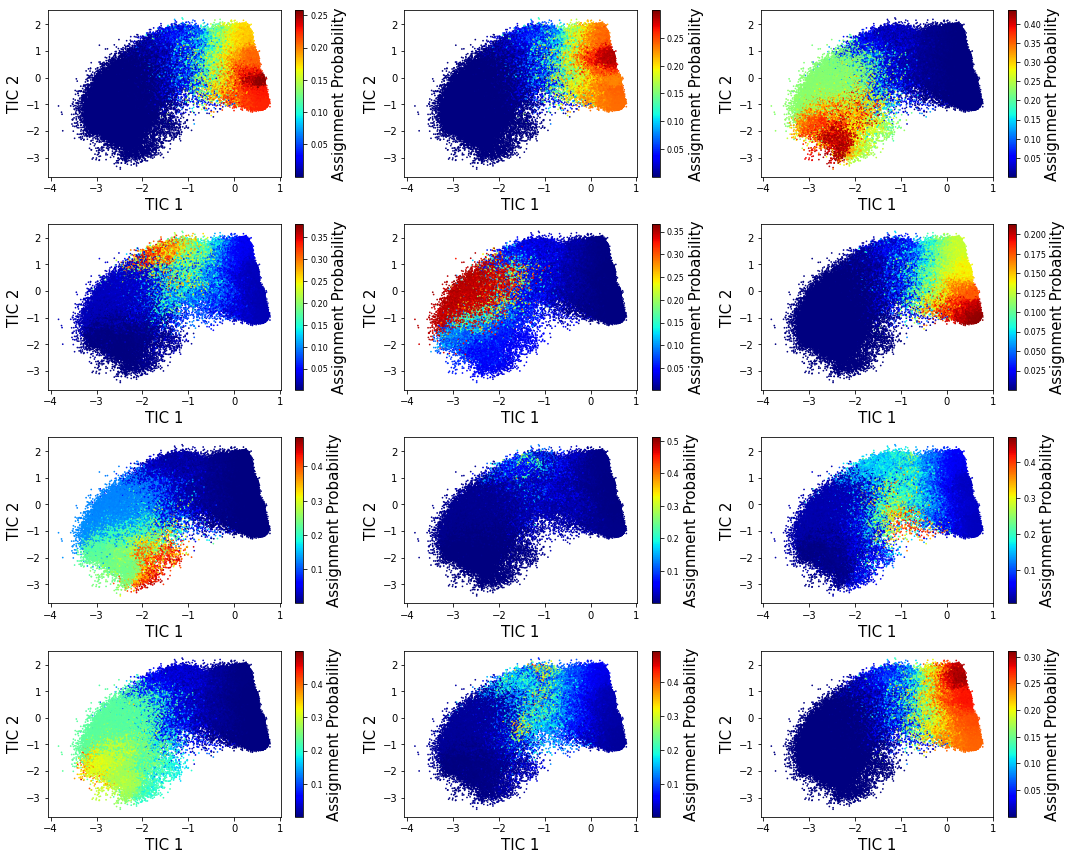

In [54]:
fig,axes = plt.subplots(4,3, figsize = (15,12))
for ax, prob in zip(axes.flat, prob_old.T):
    visualize.proj2d(tica_proj, c = prob,
                    cbar_label="Assignment Probability", ax=ax,
                    comp_type="TIC")
plt.tight_layout()

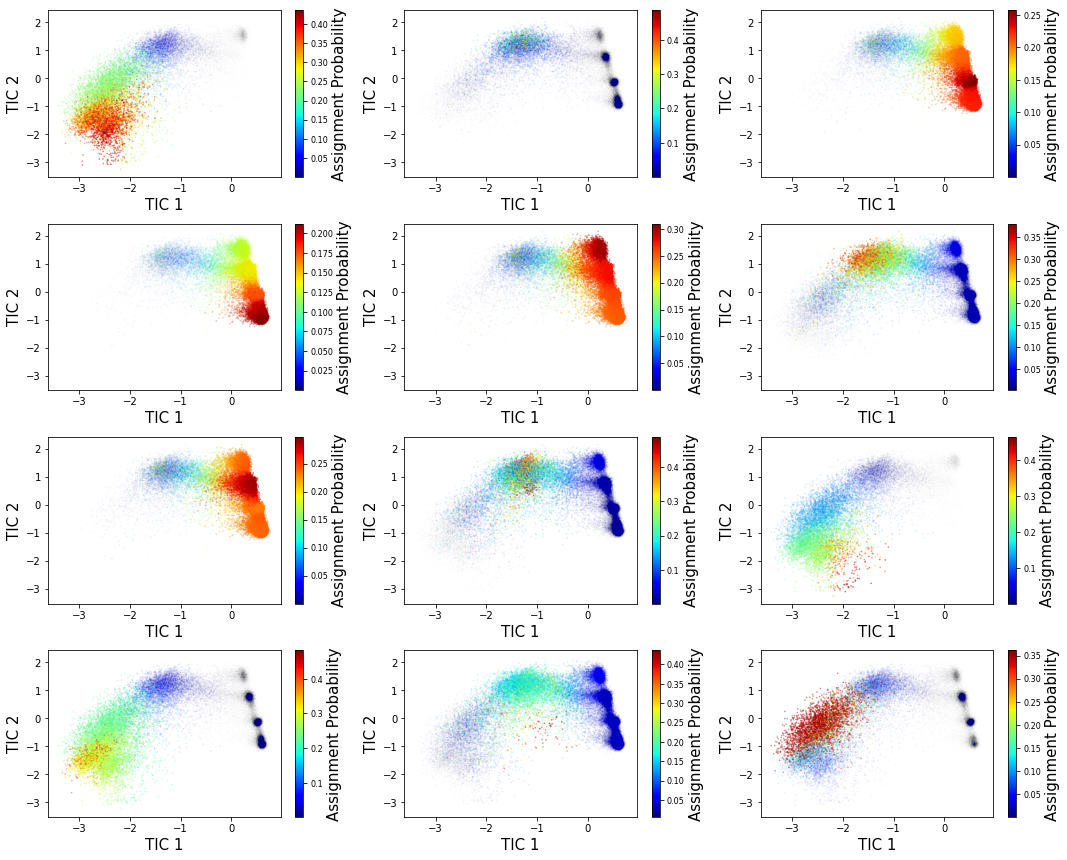

In [44]:
fig,axes = plt.subplots(4,3, figsize = (15,12))
for ax, prob in zip(axes.flat, sorted_probs[1].T):
    visualize.proj2d(tica_proj[::10], c = prob,alpha=prob,
                    cbar_label="Assignment Probability", ax=ax,
                    comp_type="TIC")
plt.tight_layout()